## Skin Deep Learning Training Notebook

In [0]:

import keras as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import tensorflow as TF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [0]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Loading and Preprocessing data

In [0]:
#Reading the metadata_csv to see what the current DataFrame looks like.

metadata_path = 'gdrive/My Drive/Google Colab Data/Skin/HAM10000_metadata.csv'
metadata = pd.read_csv(metadata_path)
metadata.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [0]:
# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [0]:
#Creating New Columns for better readability

newpath = 'gdrive/My Drive/Google Colab Data/Skin/HAM10000_images_part_1/'
metadata['path'] = metadata['image_id'].map(lambda x: newpath+x+".jpg")
print(list(metadata['path'])[6])

#Writes cell_type & cell_type_index features to the csv

metadata['cell_type'] = metadata['dx'].map(lesion_type_dict.get) 
metadata['cell_type_idx'] = pd.Categorical(metadata['cell_type']).codes
# metadata.head(5)

gdrive/My Drive/Google Colab Data/Skin/HAM10000_images_part_1/ISIC_0029176.jpg


In [0]:
#Resizing images to a 100x75x3 matrix and storing them as a new feature 
#for the DF

metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image\
.open(x).resize((100,75))))
# metadata.head(5)

KeyboardInterrupt: ignored

In [0]:
#Plotting one image to confirm that the previous step was successful
plt.figure()
plt.imshow(metadata['image'][4])

### Cleaning and Preparing Data for Training

In [0]:
X = metadata['image'].values
y = metadata['cell_type_idx'].values

In [0]:
"""nx, ny represent the image resolution of the training dataset.
When we use this model for prediction later, 
These values will be used to resize any images uploaded""" 
nx = X[1].shape[1]
ny = X[1].shape[0]

#nc by convention; Referencing the number of channels used.
nc = X[1].shape[2]
m = X.shape[0]

#reshape X to a nicer shape and print dimentions
X = np.concatenate(X).reshape(m,ny,nx,nc)
X.shape

(10015, 75, 100, 3)

In [0]:
#np.save('temp.npy', [X, y, m, ny, nx, nc])

In [0]:
 X, y, m, ny, nx, nc = np.load('gdrive/My Drive/Google Colab Data/Skin/temp.npy')

#### Randomizing and Normalizing DataFrame

In [0]:
#Randomizing and splitting the data set
train_X, test_X, train_y, test_y = train_test_split(X, y, \
test_size=0.20, random_state=3)
#Converting test and train y to one hot encode format
test_y = K.utils.to_categorical(test_y.transpose())
train_y = K.utils.to_categorical(train_y.transpose())


In [0]:
#Calculating train_X mean and standard deviation for normalization
train_X_mean = np.mean(train_X, axis=0)
train_X_std = np.std(train_X, axis=0)

#Normalization

train_X = ((train_X - train_X_mean)/train_X_std)
test_X = ((test_X - train_X_mean)/train_X_std)
#No variable generation for test set to prevent data leakage

([array([ 0.,  2., 20., 19., 11., 23.,  0.,  0.,  0.,  0.]),
  array([ 0.,  2., 19., 16., 10., 25.,  3.,  0.,  0.,  0.]),
  array([ 0.,  3., 16., 11., 12., 21., 12.,  0.,  0.,  0.]),
  array([ 0.,  3., 20.,  6.,  8., 19., 19.,  0.,  0.,  0.]),
  array([ 0.,  3., 15.,  7., 10., 17., 23.,  0.,  0.,  0.]),
  array([ 0.,  3., 11.,  6.,  8., 16., 31.,  0.,  0.,  0.]),
  array([ 1.,  2., 10.,  6.,  9., 17., 30.,  0.,  0.,  0.]),
  array([ 1.,  3.,  6.,  6., 12., 20., 27.,  0.,  0.,  0.]),
  array([ 0.,  2.,  5.,  5., 14., 17., 32.,  0.,  0.,  0.]),
  array([ 0.,  2.,  3.,  6., 11., 21., 28.,  4.,  0.,  0.]),
  array([ 1.,  1.,  2.,  8.,  6., 19., 28., 10.,  0.,  0.]),
  array([ 0.,  1.,  1.,  6.,  7., 20., 29., 11.,  0.,  0.]),
  array([ 0.,  0.,  2.,  2.,  9., 16., 35., 11.,  0.,  0.]),
  array([ 0.,  1.,  0.,  2.,  6., 19., 37., 10.,  0.,  0.]),
  array([ 0.,  0.,  0.,  1.,  7., 14., 38., 15.,  0.,  0.]),
  array([ 1.,  1.,  0.,  1.,  8.,  9., 37., 18.,  0.,  0.]),
  array([ 0.,  0.,  1., 

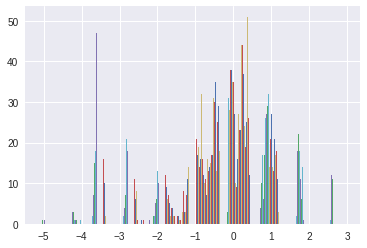

In [0]:
# Checking normalization
plt.figure()
plt.hist(train_X[5,:,:,1])

### Model Building

Created model using sequential feed. Model utilies a pair of convolutional layers with 32 filters each followed by a
max pooling layer. We use dropout for regularization to avoid overfitting the model.

We repeat the above step with more granular convolutional filters. We again use dropout with a more aggressive
dropout rate to avoid overfitting the model.

We add a dense layer using the rectified linear unit as the activation function. Regularization is applied again to 
limit overfitting.

Softmax activation layer is used to predict the 7 disease categories identified by our dataset.

In [0]:
# Setting CNN Skin model

input_shape = (75, 100, 3)
class_num = 7

model = K.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_num, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 25, 64)        0         
__________

In [0]:
# Define optimizer (Adam optimizer)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,\
                              epsilon=None, decay=0.0, amsgrad=False)

In [0]:
# Compile the model, categorical crossentropy loss and accuracy metric
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", \
             metrics = ['accuracy'])

In [0]:
history = model.fit(train_X, train_y_fixed[0], batch_size = 64, epochs = 50)
plt.figure()
plt.plot(history.history['loss'])

Epoch 1/50
1792/8012 [=====>........................] - ETA: 8s - loss: 0.1364 - acc: 0.9453

KeyboardInterrupt: ignored

In [0]:
model.evaluate(test_X, test_y)

2003/2003 [==============================] - 1s 731us/step


[1.2367386951246562, 0.7593609586216722]

In [0]:
#Saving the model and weights for the end to end solution.

#Save weights
model.save_weights("gdrive/My Drive/Google Colab Data/Skin/skinmodelweights.h5")
model_json = model.to_json()

#Save model
with open("gdrive/My Drive/Google Colab Data/Skin/skinmodel.json", "w") as file:
  file.write(model_json)
  
#Save mean and std
np.save("gdrive/My Drive/Google Colab Data/Skin/skinmodel_meanstd.npy", [train_X_mean, train_X_std])
  


In [0]:
def img_processor(imgpath, meanstdpath, modelpath, weightspath):
  """
  inputs: 
        imgpath - path to image of potential skin cancer mole;
        meanstdpath - path to training mean & standard deviation;
        modelpath - path to Keras model;
        weightspath - path to weights for Keras model
  
  output: pred_dic - a prediction dictionary with diseases as keys and probabilities as values
  """
  
  from keras.models import model_from_json
  # load model
  with open(modelpath, "r") as file:
    loaded_json = file.read()
  skinmodel = model_from_json(loaded_json)

  # Load weights from file
  skinmodel.load_weights(weightspath)
  
  # Load mean and std
  train_X_mean, train_X_std = np.load(meanstdpath)
  
  # Loading, resizing image as np.array
  imagearray = np.asarray(Image.open(imgpath).resize((100,75)))
  imagearray = ((imagearray-train_X_mean)/train_X_std)
  ny, nx, nc = imagearray.shape
  imagearray = imagearray.reshape(1 ,ny, nx, nc)
                
  pred_vec = skinmodel.predict(imagearray).flatten()
  
  pred_dict = {'Actinic keratoses' : pred_vec[0], 'Basal cell carcinoma' : pred_vec[1],
                   'Benign keratosis-like lesions' : pred_vec[2], 'Dermatofibroma' : pred_vec[3],
                   'Melanocytic nevi' : pred_vec[4], 'Melanoma' : pred_vec[5], 'Vascular lesions' : pred_vec[6]
              }
                                      
  
  return pred_dict
  

In [0]:
drive_path = 'gdrive/My Drive/Google Colab Data/Skin/'
res = img_processor(drive_path + "HAM10000_images_part_1/ISIC_0024346.jpg", drive_path + "skinmodel_meanstd.npy",\
              drive_path + "skinmodel.json", drive_path + "skinmodelweights.h5")
print(res)

{'Actinic keratoses': 1.468158e-26, 'Basal cell carcinoma': 3.5272613e-21, 'Benign keratosis-like lesions': 5.293164e-15, 'Dermatofibroma': 2.189494e-26, 'Melanocytic nevi': 1.0, 'Melanoma': 4.6992812e-14, 'Vascular lesions': 2.305058e-30}
